# Import libraries

In [1]:
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from dataset import NCFDataset
from recom_ncf import NCFRecommender
from evaluation import Evaluation
from helpers.index_manager import IndexManager
from tuner import NCFTuner
from helpers.splitter import Splitter

# Loading data

In [2]:
time_feature = 'z_timestamp'
df = pd.read_csv('../data/interaction-clean.csv')[['user_id', 'item_id', 'rating_imp', 'timestamp', 'z_timestamp']]
df.head()

user_id  item_id  rating_imp   timestamp  z_timestamp
0  76561197960432447       10           1  1738278781     0.559647
1  76561198071230926       10           1  1736206418     0.535447
2  76561198206216352       10           1  1738041574     0.556877
3  76561198110801124       10           1  1738015332     0.556570
4  76561199813732773       10           1  1737853720     0.554683

# Indexing data

In [3]:
index_manager = IndexManager()
index_manager.fit(df_interaction=df)
index_manager.transform(df, inplace=True)
df.head()

Indexed 836887 users and 69001 items
User index range: 0-836886
Item index range: 0-69000


user_id  item_id  rating_imp   timestamp  z_timestamp
0        0        0           1  1738278781     0.559647
1        1        0           1  1736206418     0.535447
2        2        0           1  1738041574     0.556877
3        3        0           1  1738015332     0.556570
4        4        0           1  1737853720     0.554683

# Splitting data

In [4]:
splitter = Splitter(df)
df_train, df_val, df_test = splitter.leave_k_out_split()

Splitting data with leave-2-out strategy (1 for validation, 1 for testing)
Total users: 836887
Interactions per user: min=1, max=1035, avg=1.4
Note: 706515 users have fewer than 2 interactions.
These users will be placed entirely in the training set.
Split complete: 1156226 total interactions
Train set: 895482 interactions (77.4%)
Validation set: 130372 interactions (11.3%)
Test set: 130372 interactions (11.3%)


# Tuning model

In [5]:
unique_users = index_manager.get_indexed_users()
unique_items = index_manager.get_indexed_items()

tuner = NCFTuner(
    train_data=df_train,
    val_data=df_val,
    test_data=df_test,
    unique_users=unique_users,
    unique_items=unique_items,
    time_feature=time_feature,
)

In [6]:
param_grid = {
            'factors': [8, 16, 32, 64],
            'mlp_user_item_dim': [32, 64, 128],
            'mlp_time_dim': [8, 16, 32, 64],
            'learning_rate': [0.0005, 0.001],
            'epochs': [100],
            'optimizer': ['adagrad'],
            'dropout': [0.0, 0.2, 0.5],
            'weight_decay': [0.0, 0.00001, 0.0001, 0.001],
            'loss_fn': ['bce', 'mse', 'bpr'],
            'batch_size': [4096, 8192, 16384],
}

tuner.set_param_grid(param_grid)


In [7]:
results, file_path = tuner.perform_random_search(num_trials=30)

Running experiment with params: {'factors': 64, 'mlp_user_item_dim': 64, 'mlp_time_dim': 64, 'learning_rate': 0.001, 'epochs': 100, 'optimizer': 'adagrad', 'dropout': 0.0, 'weight_decay': 0.001, 'loss_fn': 'mse', 'batch_size': 4096}
All weights initialized with Gaussian distribution (mean=0, std=0.01)
Epoch 1/100
Train loss: 0.616546, Validation loss: 0.484218
Epoch 2/100
Train loss: 0.455140, Validation loss: 0.462186
Epoch 3/100
Train loss: 0.431083, Validation loss: 0.452508
Epoch 4/100
Train loss: 0.407173, Validation loss: 0.443586
Epoch 5/100
Train loss: 0.380801, Validation loss: 0.437412
Epoch 6/100
Train loss: 0.355689, Validation loss: 0.434439
Epoch 7/100
Train loss: 0.329849, Validation loss: 0.432730
Epoch 8/100
Train loss: 0.300529, Validation loss: 0.433380
Epoch 9/100
Train loss: 0.267653, Validation loss: 0.437163
Epoch 10/100
Train loss: 0.233786, Validation loss: 0.444629
Early stopping triggered after 10 epochs
Training completed!
Starting evaluation preparation...


In [8]:
best_params = tuner.analyze_results()
print("Best parameters:", best_params)

Best parameters: {'Hit Ratio@10': {'params': {'factors': 32, 'mlp_user_item_dim': 32, 'mlp_time_dim': 8, 'learning_rate': 0.0005, 'epochs': 100, 'optimizer': 'adagrad', 'dropout': 0.2, 'weight_decay': 0.0, 'loss_fn': 'bpr', 'batch_size': 16384}, 'value': 0.03285981652502071}, 'NDCG@10': {'params': {'factors': 32, 'mlp_user_item_dim': 32, 'mlp_time_dim': 8, 'learning_rate': 0.0005, 'epochs': 100, 'optimizer': 'adagrad', 'dropout': 0.2, 'weight_decay': 0.0, 'loss_fn': 'bpr', 'batch_size': 16384}, 'value': 0.016618273490809826}, 'Recall@10': {'params': {'factors': 32, 'mlp_user_item_dim': 32, 'mlp_time_dim': 8, 'learning_rate': 0.0005, 'epochs': 100, 'optimizer': 'adagrad', 'dropout': 0.2, 'weight_decay': 0.0, 'loss_fn': 'bpr', 'batch_size': 16384}, 'value': 0.03285981652502071}}


# Analyzing results

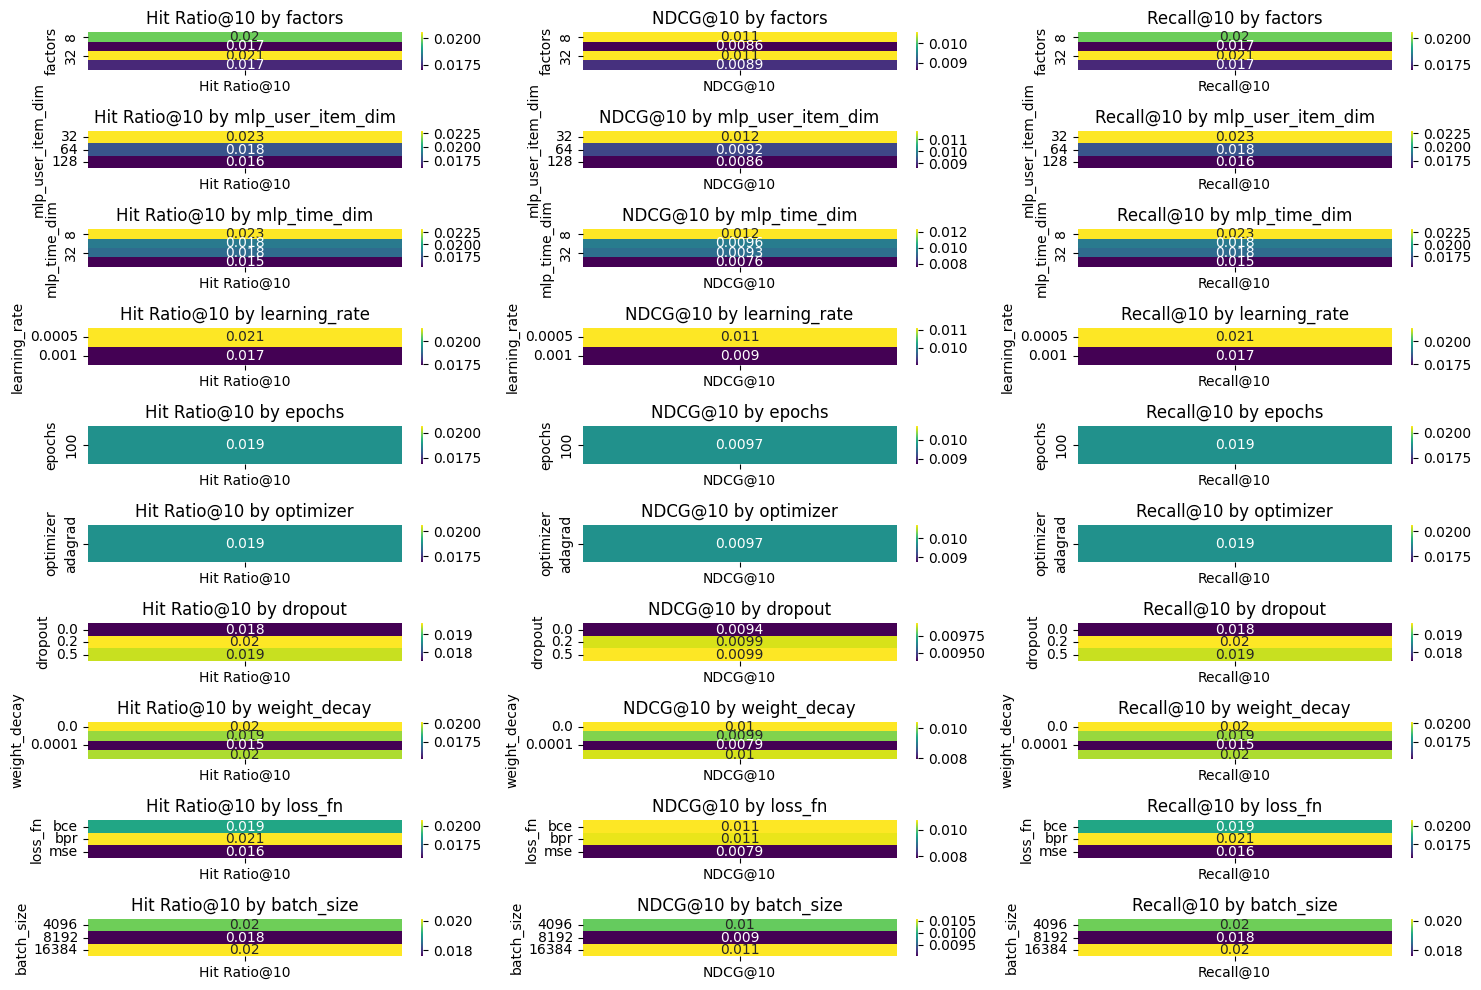

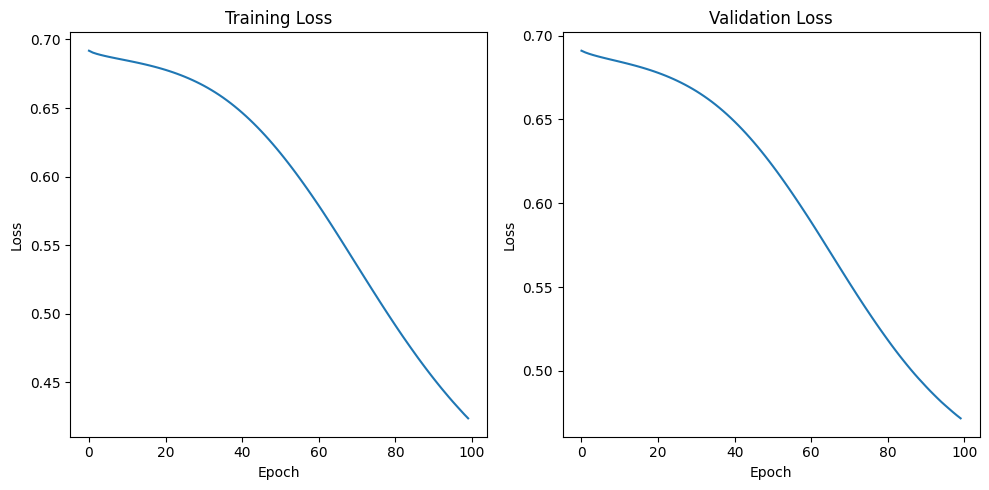

In [9]:
df_result = tuner.plot_results()

In [26]:
df_result

factors  mlp_user_item_dim  mlp_time_dim  learning_rate  epochs optimizer  \
0        64                 64            64         0.0010     100   adagrad   
1        32                 32             8         0.0005     100   adagrad   
2        64                128            16         0.0005     100   adagrad   
3        32                 32            16         0.0010     100   adagrad   
4         8                128            16         0.0005     100   adagrad   
5         8                 32            16         0.0010     100   adagrad   
6        16                 64            32         0.0010     100   adagrad   
7        16                 64            64         0.0010     100   adagrad   
8        16                 64            16         0.0010     100   adagrad   
9         8                 32            64         0.0005     100   adagrad   
10       16                128            16         0.0010     100   adagrad   
11       32                128            16         0.0005     100   adagrad   
12       16                 32             8         0.0010     100   adagrad   
13        8                 64            16         0.0010     100   adagrad   
14        8                 32            32         0.0010     100   adagrad   
15       64                 64            64         0.0010     100   adagrad   
16        8                 64            64         0.0005     100   adagrad   
17       64                128            64         0.0010     100   adagrad   
18        8                128             8         0.0010     100   adagrad   
19       32                128            32         0.0005     100   adagrad   
20        8                 64             8         0.0010     100   adagrad   
21       32                128            64         0.0005     100   adagrad   
22       64                 64            64         0.0010     100   adagrad   
23       64                 32             8         0.0010     100   adagrad   
24       64                128             8         0.0010     100   adagrad   
25       32                128            32         0.0005     100   adagrad   
26       32                 32            16         0.0010     100   adagrad   
27       16                128            32         0.0010     100   adagrad   
28        8                 64             8         0.0010     100   adagrad   
29       64                 32             8         0.0005     100   adagrad   

    dropout  weight_decay loss_fn  batch_size  Hit Ratio@10   NDCG@10  \
0       0.0       0.00100     mse        4096      0.013446  0.007307   
1       0.2       0.00000     bpr       16384      0.032860  0.016618   
2       0.5       0.00000     bce       16384      0.018018  0.010896   
3       0.5       0.00001     bpr        4096      0.021178  0.010430   
4       0.2       0.00100     bpr        8192      0.019567  0.010120   
5       0.5       0.00001     bpr        4096      0.021799  0.011973   
6       0.5       0.00001     mse        4096      0.019644  0.009444   
7       0.2       0.00010     bpr        8192      0.015448  0.007784   
8       0.5       0.00000     bpr        8192      0.019836  0.010011   
9       0.5       0.00000     mse       16384      0.018961  0.009058   
10      0.5       0.00000     bpr        8192      0.013484  0.006669   
11      0.5       0.00100     bpr        4096      0.018516  0.009125   
12      0.2       0.00001     bpr        4096      0.020848  0.011774   
13      0.2       0.00001     bce        4096      0.020280  0.010172   
14      0.0       0.00010     mse        8192      0.018746  0.009788   
15      0.2       0.00001     bpr       16384      0.015203  0.006685   
16      0.0       0.00100     mse        8192      0.019836  0.009971   
17      0.0       0.00010     mse        8192      0.006643  0.002688   
18      0.0       0.00010     bpr       16384      0.016706  0.010221   
19      0.5       0.00010     ms

# Train model with best params

In [11]:
best_param = best_params['Hit Ratio@10']['params']

train_dataset = NCFDataset(df_train, time_feature=time_feature)
val_dataset = NCFDataset(df_val, time_feature=time_feature)

dataloader_params = {
    'batch_size': best_param.pop('batch_size'),
    'num_workers': 4,
    'persistent_workers': True,
    'prefetch_factor': 2,
    'pin_memory': True,
    'shuffle': True
}

train_dataloader = DataLoader(train_dataset, **dataloader_params)
eval_dataloader = DataLoader(val_dataset, **dataloader_params)

model = NCFRecommender(unique_users, unique_items, **best_param)
model.fit(train_dataloader, eval_dataloader)

All weights initialized with Gaussian distribution (mean=0, std=0.01)
Epoch 1/100
Train loss: 0.879244, Validation loss: 0.871394
Epoch 2/100
Train loss: 0.878624, Validation loss: 0.870917
Epoch 3/100
Train loss: 0.878197, Validation loss: 0.870538
Epoch 4/100
Train loss: 0.877826, Validation loss: 0.870228
Epoch 5/100
Train loss: 0.877545, Validation loss: 0.869922
Epoch 6/100
Train loss: 0.877198, Validation loss: 0.869611
Epoch 7/100
Train loss: 0.876895, Validation loss: 0.869299
Epoch 8/100
Train loss: 0.876587, Validation loss: 0.869004
Epoch 9/100
Train loss: 0.876259, Validation loss: 0.868668
Epoch 10/100
Train loss: 0.875908, Validation loss: 0.868297
Epoch 11/100
Train loss: 0.875486, Validation loss: 0.867874
Epoch 12/100
Train loss: 0.874988, Validation loss: 0.867363
Epoch 13/100
Train loss: 0.874423, Validation loss: 0.866805
Epoch 14/100
Train loss: 0.873795, Validation loss: 0.866156
Epoch 15/100
Train loss: 0.873041, Validation loss: 0.865370
Epoch 16/100
Train loss:

In [12]:
evaluator = Evaluation(recommender=model, test_data=df_test, time_feature=time_feature)
metrics = evaluator.evaluate()

Starting evaluation preparation...
Creating ground truth sets...
Ground truth created for 130372 users with an average of 1.0 items each
Ground truth creation completed in 2.29 seconds
Extracting timestamps for each user...
Timestamp extraction completed in 0.12 seconds
Generating predictions for 130372 users...
Processing predictions for 130372 users and 69001 items
Processing 1 of 130372 users... (0.00%)
Memory usage: 0.141845703125 . Increasing batch size with increasing rate of 1.1
Increased user batch size from 128 to 141
Increased item batch size from 1024 to 1126
Processing 129 of 130372 users... (0.10%)
Memory usage: 0.093505859375 . Increasing batch size with increasing rate of 1.1
Increased user batch size from 141 to 155
Increased item batch size from 1126 to 1239
Processing 270 of 130372 users... (0.21%)
Memory usage: 0.097900390625 . Increasing batch size with increasing rate of 1.1
Increased user batch size from 155 to 170
Increased item batch size from 1239 to 1363
Proce

In [13]:
for metric in metrics.keys():
    print(f'{metric}:\t{metrics[metric]: .7f}')

Hit Ratio@10:	 0.0425782
NDCG@10:	 0.0197211
Recall@10:	 0.0425782


# Interpretting predictions

In [14]:
df_interaction_count = df.groupby('user_id')[['item_id']].nunique().sort_values('item_id', ascending=False)

In [15]:
df_interaction_count[df_interaction_count['item_id'] == 10]

item_id
user_id         
141666        10
158712        10
50193         10
255627        10
52048         10
...          ...
118056        10
356725        10
17134         10
24418         10
97850         10

[661 rows x 1 columns]

In [16]:
user_id = 141666

In [17]:
df[df['user_id'] == user_id]

user_id  item_id  rating_imp   timestamp  z_timestamp
158130    141666    33017           0  1641471440    -0.570794
168364    141666    33789           0  1612374138    -0.910569
324424    141666    45795           1  1704051359     0.159966
384844    141666    50159           0  1703965957     0.158968
699841    141666     3261           0  1412768342    -3.241410
963573    141666    12581           0  1700307490     0.116248
986333    141666    13777           1  1672305769    -0.210735
1012781   141666    15355           1  1610746559    -0.929575
1028380   141666    16342           0  1690715633     0.004241
1110849   141666    21866           1  1672441918    -0.209145

In [18]:
predictions = model.batch_predict_for_users([user_id], [1704051359])

Processing predictions for 1 users and 69001 items
Processing 1 of 1 users... (0.00%)
Memory usage: 0.0859375 . Increasing batch size with increasing rate of 1.1
Increased user batch size from 1024 to 1126
Increased item batch size from 8096 to 8906
Prediction completed in 0.24 seconds


In [19]:
predictions

{141666: [23003,
  23005,
  23010,
  22997,
  23002,
  23001,
  23000,
  22999,
  22998,
  69000]}

## Metadata

In [20]:
df_metadata = pd.read_csv('../data/metadata-clean.csv')
df_metadata.head()

name  item_id  \
0               Clash of Warlords  1430720   
1  Mine Crazy: The Korean Grinder  1430740   
2                            Fade  1430100   
3       Clash: Artifacts of Chaos  1430680   
4                         Astatos  1430970   

                                 supported_languages  \
0      ['Simplified Chinese', 'Traditional Chinese']   
1                                        ['English']   
2                                        ['English']   
3  ['English', 'French', 'Italian', 'German', 'Sp...   
4  ['English', 'Simplified Chinese', 'Traditional...   

                      developers           publishers  \
0              ['XINLINE GAMES']    ['XINLINE GAMES']   
1                  ['Dano Sato']    ['RealMono Inc.']   
2            ['Azimyth Studios']  ['Azimyth Studios']   
3                   ['ACE Team']            ['Nacon']   
4  ['Studio Klondike Australia']  ['Studio Klondike']   

                                          categories  \
0  ['Single-player', 'In-App Purchases', 'Family ...   
1                ['Single-player', 'Family Sharing']   
2                ['Single-player', 'Family Sharing']   
3  ['Single-player', 'Steam Achievements', 'Steam...   
4  ['Single-player', 'Multi-player', 'PvP', 'Onli...   

                                              genres  total_recommendations  \
0                                       ['Strategy']                      0   
1           ['Casual', 'Indie', 'RPG', 'Simulation']                      0   
2                                   ['Indie', 'RPG']                      0   
3                   ['Action', 'Adventure', 'Indie']                    759   
4  ['Adventure', 'Indie', 'Strategy', 'Early Acce...                    243   

  released_date                                               tags   price  
0    2021-02-07  ['Turn-Based Tactics', 'Strategy', 'Wargame', ...   699.0  
1    2020-10-08  ['Casual', 'RPG', 'Simulation', 'Clicker', 'Fa...   199.0  
2    2020-10-29  ['Horror', 'RPG', 'Survival Horror', 'Top-Down...   199.0  
3    2023-03-09  ['Action', 'Adventure', 'RPG', 'Souls-like', '...  2999.0  
4    2021-12-16  ['Early Access', 'Visual Novel', 'Card Battler...  1499.0

## User actual items

In [21]:
user_actual_items = df[(df['user_id'] == user_id)]['item_id'].values
user_actual_items = [index_manager.item_idx_to_id[item] for item in user_actual_items]
user_actual_items

[1281200,
 1309700,
 1796130,
 1982630,
 302910,
 586130,
 624330,
 676730,
 706690,
 886610]

In [22]:
df_metadata[df_metadata['item_id'].isin(user_actual_items)][['name', 'item_id', 'publishers', 'genres', 'tags']]

name  item_id  \
8874            The Mystery of Happyville   886610   
15846                     Megatronic Void   706690   
17043                     Behind The Door   676730   
22917                     Exorcism Ritual  1982630   
23322                       Devil's dream  1309700   
32469  The Walking Fish 2: Final Frontier  1281200   
41865                           The House   302910   
70976                     Survival Driver   586130   
85275              Scare: Project of Fear  1796130   

                             publishers  \
8874                      ['Studio HK']   
15846                ['Conglomerate 5']   
17043               ['Dio Alias Games']   
22917                      ['Antitesa']   
23322                  ['Milkoi Games']   
32469  ['That Fish', 'That Other Fish']   
41865                      ['Konsordo']   
70976                    ['HaDe Games']   
85275                            ['HV']   

                                                  genres  \
8874   ['Violent', 'Gore', 'Action', 'Adventure', 'Ca...   
15846                                ['Action', 'Indie']   
17043                             ['Adventure', 'Indie']   
22917                                ['Action', 'Indie']   
23322                                          ['Indie']   
32469                             ['Adventure', 'Indie']   
41865                   ['Action', 'Adventure', 'Indie']   
70976                      ['Casual', 'Indie', 'Racing']   
85275     ['Action', 'Adventure', 'Indie', 'Simulation']   

                                                    tags  
8874   ['Action', 'Adventure', 'Indie', 'Casual', 'Go...  
15846  ['Action', 'Indie', 'Platformer', 'Adventure',...  
17043  ['Indie', 'Adventure', 'Puzzle', 'Horror', 'Po...  
22917  ['Action', 'Puzzle', 'Shooter', 'FPS', 'Realis...  
23322  ['Indie', 'First-Person', 'Horror', 'Survival ...  
32469  ['Adventure', 'Indie', 'Horror', 'Surreal', 'C...  
41865  ['Horror', 'Indie', 'Action', 'Adventure', 'Wa...  
70976                      ['Indie', 'Racing', 'Casual']  
85275  ['Survival Horror', 'Psychological Horror', 'S...

## Predicted items

In [23]:
predictions = [index_manager.item_idx_to_id[item] for item in predictions[user_id]]
predictions

[929460,
 929510,
 929640,
 929320,
 929440,
 929430,
 929420,
 929410,
 929400,
 3467390]

In [24]:
df_prediction = df_metadata[df_metadata['item_id'].isin(predictions)][['name', 'item_id', 'publishers', 'genres', 'tags']]
df_prediction

name  item_id              publishers  \
7365              Money Master   929460  ['Happy Home Company']   
7368              Type Fighter   929510        ['Simon Harvey']   
7373               Farragnarok   929640     ['Farrago Fiction']   
7392      RHEM II SE: The Cave   929320       ['Runesoft GmbH']   
7394   Mahjong Magic Journey 3   929400              ['8floor']   
7395       Christmas Mahjong 2   929410              ['8floor']   
7396      Sakura Day 2 Mahjong   929420              ['8floor']   
7397   Mahjong Magic Journey 2   929430              ['8floor']   
7398         Christmas Mahjong   929440              ['8floor']   
81705            DON'T GET GOT  3467390          ['CULT Games']   

                                         genres  \
7365                   ['Casual', 'Simulation']   
7368                                 ['Action']   
7373   ['Casual', 'Simulation', 'Early Access']   
7392                              ['Adventure']   
7394                                 ['Casual']   
7395                                 ['Casual']   
7396                                 ['Casual']   
7397                                 ['Casual']   
7398                                 ['Casual']   
81705                ['Action', 'Early Access']   

                                                    tags  
7365              ['Casual', 'Simulation', 'Board Game']  
7368   ['Action', 'Pixel Graphics', 'Typing', 'Casual...  
7373            ['Early Access', 'Casual', 'Simulation']  
7392   ['Adventure', 'Point & Click', 'Singleplayer',...  
7394   ['Casual', 'Mahjong', 'Puzzle', 'Board Game', ...  
7395   ['Casual', 'Mahjong', 'Puzzle', 'Board Game', ...  
7396   ['Casual', 'Puzzle', 'Mahjong', 'Board Game', ...  
7397   ['Casual', 'Mahjong', 'Puzzle', 'Board Game', ...  
7398   ['Casual', 'Mahjong', 'Puzzle', 'Romance', 'Nu...  
81705  ['Early Access', 'Horror', 'Multiplayer', 'Onl...

In [25]:
import webbrowser
base_url = 'https://store.steampowered.com/agecheck/app/'

item_ids = df_prediction['item_id'].values
for item_id in item_ids:
    webbrowser.open(f'{base_url}{item_id}')